# Projet de prédiction du trafic du RER E jusqu'en 2027

## Introduction

Ce notebook présente notre projet d'analyse et de prédiction du trafic du RER E au premier trimestre 2027, incluant l'extension ouest prévue. Le RER E est l'une des lignes les plus importantes du réseau de transport francilien, et son prolongement vers l'ouest représente un changement majeur dans le réseau de transport parisien.

### Contexte du projet

Le prolongement du RER E vers l'ouest (projet EOLE) est l'un des plus grands projets d'infrastructure de transport en Île-de-France. Cette extension permettra de relier l'est et l'ouest de la région parisienne sans passer par le centre de Paris, ce qui devrait décharger les lignes RER A et B ainsi que plusieurs lignes de métro.

Les stations qui feront partie de cette extension sont :
- NANTERRE-LA-FOLIE
- HOUILLES-CARRIERES-SUR-SEINE
- POISSY
- VILLENNES-SUR-SEINE
- VERNOUILLET-VERNEUIL
- LES CLAIRIERES-DE-VERNEUIL
- LES MUREAUX
- AUBERGENVILLE-ELISABETHVILLE
- EPONE-MEZIERES
- MANTES-STATION
- MANTES-LA-JOLIE

### Objectifs du projet

1. Prédire le trafic voyageurs sur le RER E au premier trimestre 2027. 
2. Évaluer l'impact de l'extension ouest sur la fréquentation globale de la ligne
3. Analyser les validations par station en tenant compte du nombre de correspondances
4. Identifier les stations qui généreront le plus de trafic propre à la ligne

## 1. Préparation de l'environnement et chargement des données

In [5]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import warnings

# Configuration de l'affichage
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)

In [6]:
# Définition des stations du prolongement ouest du RER E
stations_rer_e_ouest = [
    "NANTERRE-LA-FOLIE",
    "HOUILLES-CARRIERES-SUR-SEINE",
    "POISSY",
    "VILLENNES-SUR-SEINE",
    "VERNOUILLET-VERNEUIL",
    "LES CLAIRIERES-DE-VERNEUIL",
    "LES MUREAUX",
    "AUBERGENVILLE-ELISABETHVILLE",
    "EPONE-MEZIERES",
    "MANTES-STATION",
    "MANTES-LA-JOLIE"
]

# Chargement des données des stations du RER E
df_lignes = pd.read_csv('final_data/df_lignes_ferrees.csv')
df_rer_e = df_lignes[df_lignes['ligne_res'] == 'RER E']['LIBELLE_ARRET'].unique()
rer_e = list(df_rer_e)

# Fusion des listes de stations (actuelles + futures)
all_stations = list(set(rer_e + stations_rer_e_ouest))

# Affichage du nombre de stations
print(f"Nombre de stations actuelles du RER E: {len(rer_e)}")
print(f"Nombre de stations de l'extension ouest: {len(stations_rer_e_ouest)}")
print(f"Nombre total de stations prévues en 2027: {len(all_stations)}")

Nombre de stations actuelles du RER E: 25
Nombre de stations de l'extension ouest: 11
Nombre total de stations prévues en 2027: 36


## 2. Analyse des correspondances par station

Pour mieux comprendre l'impact réel de chaque station, nous devons prendre en compte le nombre de correspondances. Une station avec de nombreuses correspondances peut avoir un nombre élevé de validations qui ne sont pas spécifiquement liées au RER E. Exemple la station Porte Maillot est desservie par le RER E, RER C et métro 1 (les trams ne sont pas pris en compte) ainsi cette station à 3 lignes. Nous déciderons donc dans le calcul du nombre d'affluence à cette station de diviser le résultat par 3.

In [7]:
# Fonction pour calculer le nombre de correspondances par station
def calculer_correspondances(df, rer_e):
    """
    Calcule le nombre de correspondances par station en excluant les tramways
    """
    correspondances = {}
    
    for station in rer_e:
        # Filtrer les lignes pour cette station
        lignes_station = df[df['LIBELLE_ARRET'] == station]['ligne_res'].tolist()
        
        # Compter uniquement les lignes non-tramway
        unique_lines = set()
        for ligne in lignes_station:
            if ligne[:4] != 'TRAM':
                unique_lines.add(ligne)
        
        correspondances[station] = len(unique_lines)
    
    return correspondances

# Calcul des correspondances pour toutes les stations
correspondances = calculer_correspondances(df_lignes, rer_e)

# Pour les stations de l'extension ouest qui n'existent pas encore dans df_lignes_ferrees.csv,
# on leur attribue 1 correspondance par défaut
for station in stations_rer_e_ouest:
    if station not in correspondances:
        correspondances[station] = 1

# Création d'un DataFrame pour visualiser les correspondances
df_correspondances = pd.DataFrame(list(correspondances.items()), columns=['Station', 'Correspondances'])
df_correspondances['Extension_Ouest'] = df_correspondances['Station'].isin(stations_rer_e_ouest)

# Affichage des 10 stations avec le plus de correspondances
df_correspondances.sort_values('Correspondances', ascending=False).head(10)

,Station,Correspondances,Extension_Ouest
21,SAINT-LAZARE,7,False
7,LA DEFENSE-GRANDE ARCHE,5,False
6,LA DEFENSE,5,False
16,PORTE MAILLOT,3,False
22,TOURNAN,2,False
23,VAL-DE-FONTENAY,2,False
19,ROSNY-BOIS-PERRIER,2,False
1,CHELLES-GOURNAY,2,False
3,EMERAINVILLE-PONTAULT-COMBAULT,1,False
2,CHENAY-GAGNY,1,False


## 3. Chargement des données historiques et prédictions

In [9]:
# Chargement des données historiques
historique_df = pd.read_csv('final_data/df_rer_e.csv', parse_dates=['JOUR'])

# Renommer les colonnes pour correspondre à notre format
historique_df = historique_df.rename(columns={
    'JOUR': 'ds',
    'NB_VALD': 'y'
})

# Aperçu des données historiques
historique_df.head()

,ds,LIBELLE_ARRET,LIBELLE_ARRET_clean,y,DAY_OF_YEAR,WEEK_OF_YEAR,DAY_OF_WEEK,IS_FERIE,IS_WEEKEND,IS_VACANCE
0,2015-01-01,AUBERGENVILLE-ELISABETHVILLE,AUBERGENVILLEELISABETHVILLE,163,1,1,3,1,0,1
1,2015-01-01,EPONE-MEZIERES,EPONEMEZIERES,61,1,1,3,1,0,1
2,2015-01-01,HOUILLES-CARRIERES-SUR-SEINE,HOUILLESCARRIERESSURSEINE,1080,1,1,3,1,0,1
3,2015-01-01,LES CLAIRIERES-DE-VERNEUIL,LESCLAIRIERESDEVERNEUIL,68,1,1,3,1,0,1
4,2015-01-01,LES MUREAUX,LESMUREAUX,719,1,1,3,1,0,1


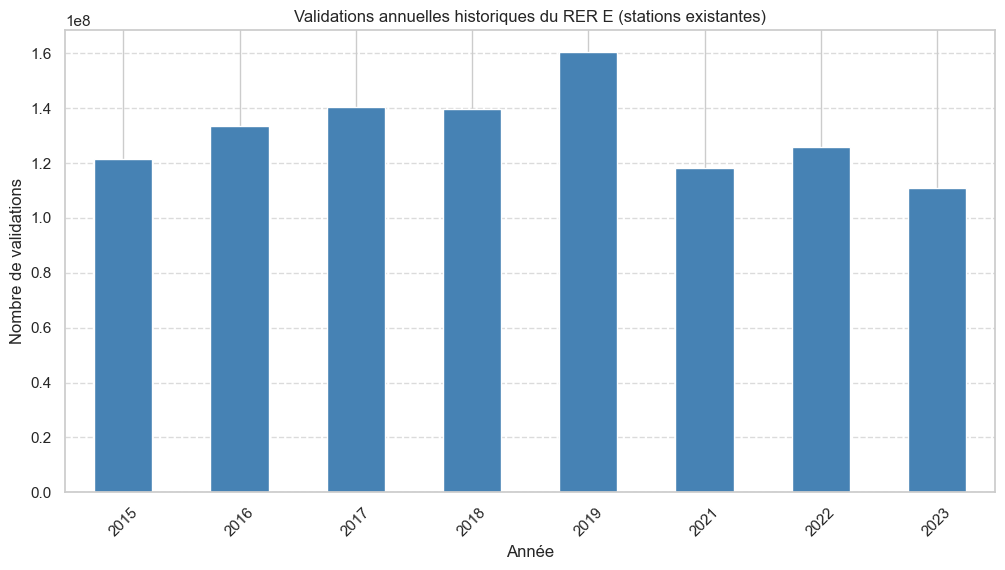

In [10]:
# Filtrer pour ne garder que les stations du RER E existantes (hors extension ouest)
stations_existantes = set(rer_e) - set(stations_rer_e_ouest)
historique_df_rer_e = historique_df[historique_df['LIBELLE_ARRET'].isin(stations_existantes)]

# Calculer l'affluence totale par année pour les stations existantes
historique_df_rer_e['year'] = historique_df_rer_e['ds'].dt.year
historique_df_rer_e['quarter'] = historique_df_rer_e['ds'].dt.quarter
yearly_totals = historique_df_rer_e.groupby('year')['y'].sum()

# Visualisation des validations annuelles historiques
plt.figure(figsize=(12, 6))
yearly_totals.plot(kind='bar', color='steelblue')
plt.title('Validations annuelles historiques du RER E (stations existantes)')
plt.xlabel('Année')
plt.ylabel('Nombre de validations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

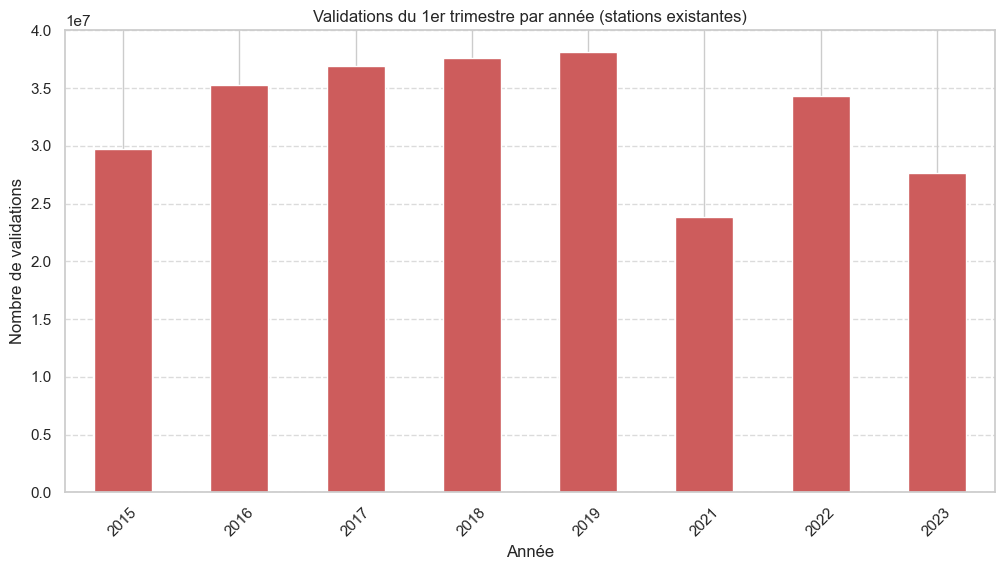

In [11]:
# Calculer l'affluence pour le 1er trimestre de chaque année (stations existantes)
q1_totals = historique_df_rer_e[historique_df_rer_e['quarter'] == 1].groupby('year')['y'].sum()

# Visualisation des validations du 1er trimestre par année
plt.figure(figsize=(12, 6))
q1_totals.plot(kind='bar', color='indianred')
plt.title('Validations du 1er trimestre par année (stations existantes)')
plt.xlabel('Année')
plt.ylabel('Nombre de validations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

## 4. Modèle de prédiction SARIMAX

Le modèle SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) est utilisé pour prédire les validations futures. Il prend en compte la saisonnalité hebdomadaire, les tendances à long terme et des facteurs externes comme les jours fériés et les vacances scolaires.

Notre modèle SARIMAX utilise les paramètres suivants :
- Ordre (p,d,q) = (2,1,2) : Composante ARIMA non saisonnière
  * p=2 : Ordre autorégressif
  * d=1 : Ordre de différenciation
  * q=2 : Ordre de moyenne mobile

- Ordre saisonnier (P,D,Q,s) = (1,0,1,7) : Composante saisonnière
  * P=1 : Ordre autorégressif saisonnier
  * D=0 : Ordre de différenciation saisonnière
  * Q=1 : Ordre de moyenne mobile saisonnière
  * s=7 : Période saisonnière (hebdomadaire)

Variables exogènes utilisées:
- DAY_OF_WEEK : Jour de la semaine (0-6)
- IS_WEEKEND : Indicateur de weekend (0 ou 1)
- IS_VACANCE : Indicateur de vacances scolaires (0 ou 1)

Traitement des données:
- Transformation logarithmique pour stabiliser la variance
- Normalisation Min-Max pour mettre à l'échelle les données
- Transformation inverse pour les prédictions finales

In [15]:
# Chargement des prédictions pour 2027

#from model_serie_temporelle.sarimax_model_rer_e_2027 import sarimax_model_rer_e_2027
#result = sarimax_model_rer_e_2027('LES MUREAUX', []) #cela permet d'avoir la prédiction au 1er trimestre 2027 sur les Mureaux sous forme de df
#30 secondes par stations

#On a au préalablement exécuter le code sur toutes les stations et enreigistré les résultat en CSV. (cela prend environ 10min max)
predictions_2027 = pd.read_csv('final_data/prediction_rer_e_2027.csv', parse_dates=['ds'])

# Aperçu des prédictions
predictions_2027.head()

,ds,LIBELLE_ARRET,yhat
0,2027-01-01,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,4832
1,2027-01-02,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,3111
2,2027-01-03,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,3036
3,2027-01-04,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,6540
4,2027-01-05,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,7132


## 5. Analyse des prédictions pour 2027 avec ajustement des correspondances

Pour le premier trimestre 2027, nous ajoutons une correspondance supplémentaire aux stations de l'extension ouest car elles seront desservies par le RER E mais elles sont également desservi par d'autres J, N, RER A etc...

In [16]:
# Préparation des correspondances pour 2027
# Pour les stations de l'extension ouest, on ajoute 1 correspondance car elles seront desservies par le RER E
correspondances_2027 = correspondances.copy()
for station in stations_rer_e_ouest:
    correspondances_2027[station] += 1

# Création d'un DataFrame avec les prédictions ajustées selon les correspondances
adjusted_df = predictions_2027.copy()
adjusted_df['nb_correspondances'] = adjusted_df['LIBELLE_ARRET'].map(correspondances_2027)
adjusted_df['yhat_adjusted'] = adjusted_df.apply(lambda row: row['yhat'] / row['nb_correspondances'], axis=1)

# Aperçu du DataFrame ajusté
adjusted_df.head()

,ds,LIBELLE_ARRET,yhat,nb_correspondances,yhat_adjusted
0,2027-01-01,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,4832,1,4832.0
1,2027-01-02,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,3111,1,3111.0
2,2027-01-03,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,3036,1,3036.0
3,2027-01-04,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,6540,1,6540.0
4,2027-01-05,VILLIERS-SUR-MARNE-PLESSIS-TREVISE,7132,1,7132.0


In [17]:
# Calcul des statistiques pour le premier trimestre 2027
# Stations existantes
pred_brut_existantes = adjusted_df[~adjusted_df['LIBELLE_ARRET'].isin(stations_rer_e_ouest)]['yhat'].sum()
pred_ajuste_existantes = adjusted_df[~adjusted_df['LIBELLE_ARRET'].isin(stations_rer_e_ouest)]['yhat_adjusted'].sum()

# Extension ouest
pred_brut_ouest = adjusted_df[adjusted_df['LIBELLE_ARRET'].isin(stations_rer_e_ouest)]['yhat'].sum()
pred_ajuste_ouest = adjusted_df[adjusted_df['LIBELLE_ARRET'].isin(stations_rer_e_ouest)]['yhat_adjusted'].sum()

# Total
pred_brut_total = adjusted_df['yhat'].sum()
pred_ajuste_total = adjusted_df['yhat_adjusted'].sum()

# Calculer les pourcentages
pourcentage_ouest_brut = (pred_brut_ouest / pred_brut_total) * 100
pourcentage_ouest_ajuste = (pred_ajuste_ouest / pred_ajuste_total) * 100

# Affichage des résultats
print(f"Prédictions pour le premier trimestre 2027:")
print(f"\nStations existantes:")
print(f"  Validations brutes: {pred_brut_existantes:,.0f}".replace(',', ' '))
print(f"  Validations ajustées: {pred_ajuste_existantes:,.0f}".replace(',', ' '))

print(f"\nStations de l'extension ouest:")
print(f"  Validations brutes: {pred_brut_ouest:,.0f}".replace(',', ' '))
print(f"  Validations ajustées: {pred_ajuste_ouest:,.0f}".replace(',', ' '))

print(f"\nTotal RER E complet:")
print(f"  Validations brutes: {pred_brut_total:,.0f}".replace(',', ' '))
print(f"  Validations ajustées: {pred_ajuste_total:,.0f}".replace(',', ' '))

print(f"\nContribution de l'extension ouest:")
print(f"  En validations brutes: {pourcentage_ouest_brut:.2f}%")
print(f"  En validations ajustées: {pourcentage_ouest_ajuste:.2f}%")

Prédictions pour le premier trimestre 2027:

Stations existantes:
  Validations brutes: 34 144 944
  Validations ajustées: 13 117 142

Stations de l'extension ouest:
  Validations brutes: 5 513 572
  Validations ajustées: 2 756 786

Total RER E complet:
  Validations brutes: 39 658 516
  Validations ajustées: 15 873 928

Contribution de l'extension ouest:
  En validations brutes: 13.90%
  En validations ajustées: 17.37%


In [19]:
# Analyse détaillée des stations de l'extension ouest
stations_ouest_df = adjusted_df[adjusted_df['LIBELLE_ARRET'].isin(stations_rer_e_ouest)]
stations_details = []

for station in stations_rer_e_ouest:
    station_df = stations_ouest_df[stations_ouest_df['LIBELLE_ARRET'] == station]
    if not station_df.empty:
        brut = station_df['yhat'].sum()
        ajuste = station_df['yhat_adjusted'].sum()
        nb_corresp = station_df['nb_correspondances'].iloc[0]
        stations_details.append((station, brut, ajuste, nb_corresp))

# Trier par validations brutes décroissantes
stations_details.sort(key=lambda x: x[1], reverse=True)

# Création d'un DataFrame pour l'analyse
df_stations_ouest = pd.DataFrame(stations_details, 
                                columns=['Station', 'Validations_brutes', 'Validations_ajustées', 'Correspondances'])

# Affichage du tableau
df_stations_ouest

,Station,Validations_brutes,Validations_ajustées,Correspondances
0,HOUILLES-CARRIERES-SUR-SEINE,1480750,740375.0,2
1,POISSY,1409397,704698.5,2
2,NANTERRE-LA-FOLIE,1357108,678554.0,2
3,LES MUREAUX,348347,174173.5,2
4,MANTES-LA-JOLIE,269329,134664.5,2
5,VERNOUILLET-VERNEUIL,255506,127753.0,2
6,AUBERGENVILLE-ELISABETHVILLE,145680,72840.0,2
7,MANTES-STATION,95543,47771.5,2
8,EPONE-MEZIERES,67372,33686.0,2
9,VILLENNES-SUR-SEINE,45062,22531.0,2


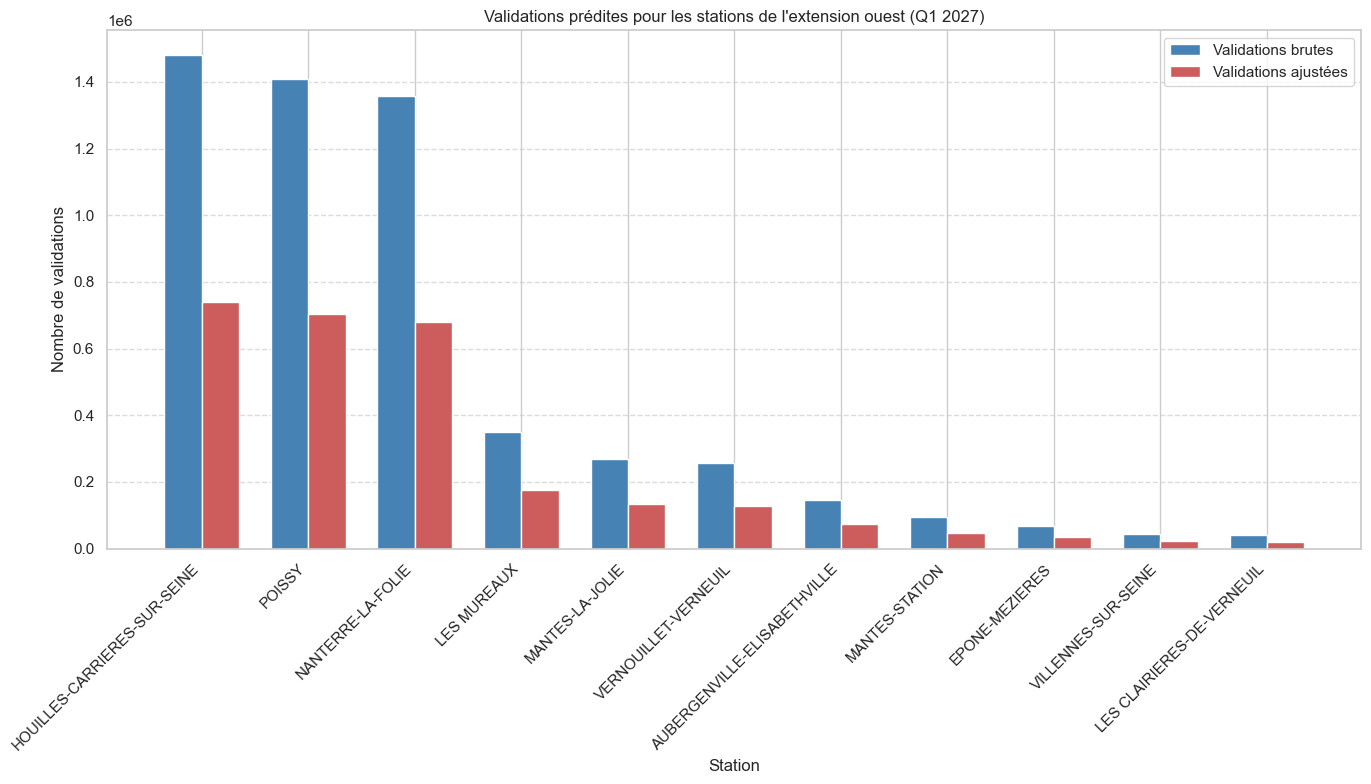

In [20]:
# Visualisation des validations brutes et ajustées pour les stations de l'extension ouest
plt.figure(figsize=(14, 8))

# Création du barplot
x = np.arange(len(df_stations_ouest))
width = 0.35

plt.bar(x - width/2, df_stations_ouest['Validations_brutes'], width, label='Validations brutes', color='steelblue')
plt.bar(x + width/2, df_stations_ouest['Validations_ajustées'], width, label='Validations ajustées', color='indianred')

plt.xlabel('Station')
plt.ylabel('Nombre de validations')
plt.title('Validations prédites pour les stations de l\'extension ouest (Q1 2027)')
plt.xticks(x, df_stations_ouest['Station'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Top des stations avec le plus de validations ajustées

Voyons quelles stations génèrent le plus de trafic propre à la ligne RER E, une fois ajustées par le nombre de correspondances.

In [21]:
# Top 10 des stations avec le plus de validations (ajustées)
top_stations = adjusted_df.groupby('LIBELLE_ARRET').agg({
    'yhat': 'sum',
    'yhat_adjusted': 'sum',
    'nb_correspondances': 'first'
}).sort_values('yhat_adjusted', ascending=False).head(10)

# Ajout d'une colonne pour indiquer si la station fait partie de l'extension ouest
top_stations['Extension_Ouest'] = top_stations.index.isin(stations_rer_e_ouest)

# Affichage du top 10
top_stations

,yhat,yhat_adjusted,nb_correspondances,Extension_Ouest
LIBELLE_ARRET,,,,
SAINT-LAZARE,19155384,2.736483e+06,7,False
NOISY-LE-SEC,1296067,1.296067e+06,1,False
ROSA PARKS,1183667,1.183667e+06,1,False
VAL-DE-FONTENAY,2004570,1.002285e+06,2,False
HOUILLES-CARRIERES-SUR-SEINE,1480750,7.403750e+05,2,True
PANTIN,727904,7.279040e+05,1,False
POISSY,1409397,7.046985e+05,2,True
NANTERRE-LA-FOLIE,1357108,6.785540e+05,2,True
PORTE MAILLOT,1876292,6.254307e+05,3,False


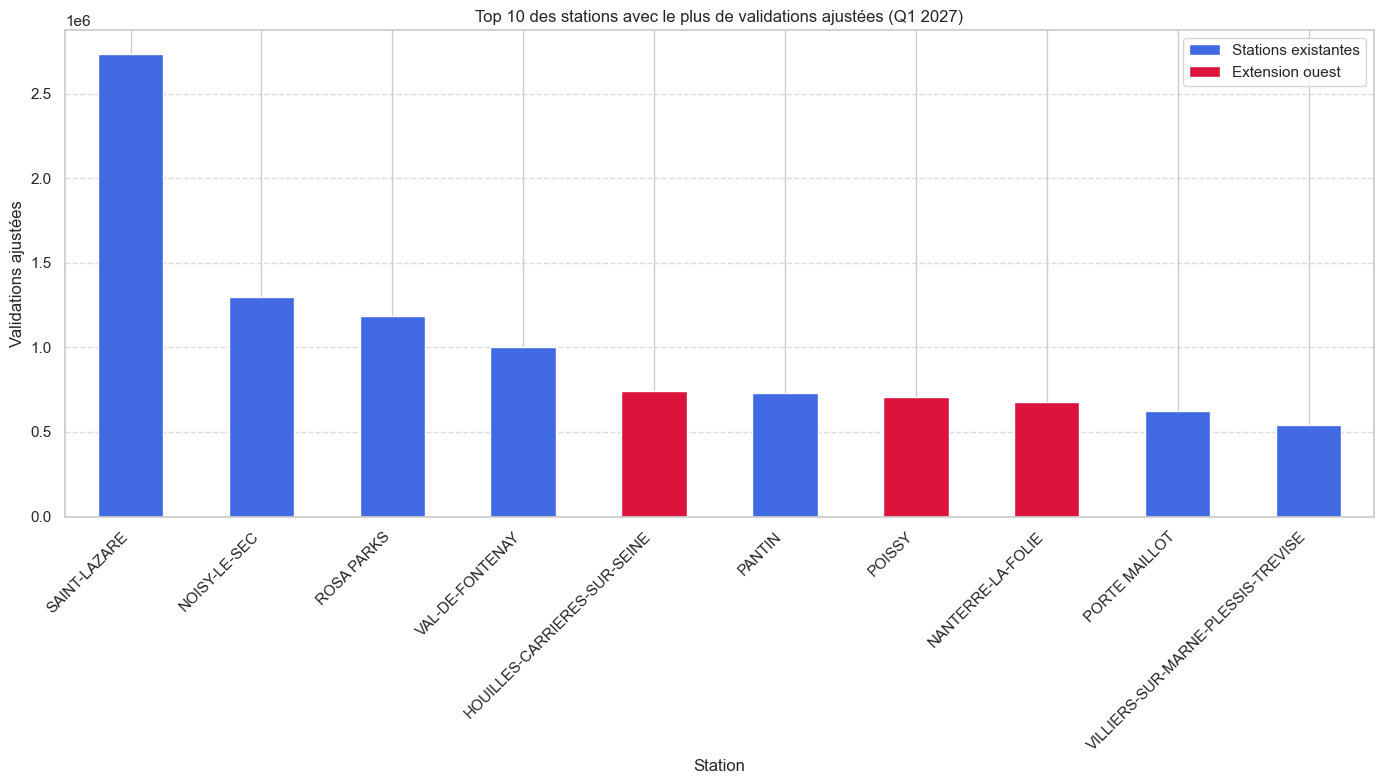

In [23]:
# Visualisation du top 10 des stations par validations ajustées
plt.figure(figsize=(14, 8))

# Création du barplot
colors = ['crimson' if ext else 'royalblue' for ext in top_stations['Extension_Ouest']]
top_stations['yhat_adjusted'].plot(kind='bar', color=colors)

plt.title('Top 10 des stations avec le plus de validations ajustées (Q1 2027)')
plt.xlabel('Station')
plt.ylabel('Validations ajustées')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Ajout d'une légende pour distinguer les stations de l'extension ouest
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='royalblue', label='Stations existantes'),
                   Patch(facecolor='crimson', label='Extension ouest')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()
#La Defense n'est pas dans le top car il a sans doute eu un problème dans les données ou bien la division a biaisé ces résultat.

## 8. Calcul de l'augmentation par rapport au dernier trimestre historique

In [24]:
# Ajuster les données historiques avec les correspondances
historique_df_rer_e['nb_correspondances'] = historique_df_rer_e['LIBELLE_ARRET'].map(correspondances)
historique_df_rer_e['y_adjusted'] = historique_df_rer_e.apply(lambda row: row['y'] / row['nb_correspondances'], axis=1)

# Identifier la dernière année avec des données complètes
derniere_annee = q1_totals.index.max()
dernier_q1 = q1_totals[derniere_annee]
dernier_q1_ajuste = historique_df_rer_e[
    (historique_df_rer_e['year'] == derniere_annee) & 
    (historique_df_rer_e['quarter'] == 1)
].groupby('year')['y_adjusted'].sum()[derniere_annee]

# Calcul des taux de croissance
croissance_brute = ((pred_brut_existantes / dernier_q1) - 1) * 100
croissance_ajustee = ((pred_ajuste_existantes / dernier_q1_ajuste) - 1) * 100
augmentation_brute = ((pred_brut_total / dernier_q1) - 1) * 100
augmentation_ajustee = ((pred_ajuste_total / dernier_q1_ajuste) - 1) * 100

# Affichage des résultats
print(f"Croissance par rapport à Q1 {derniere_annee} pour les stations existantes:")
print(f"  Brut: {croissance_brute:.2f}%")
print(f"  Ajusté par correspondances: {croissance_ajustee:.2f}%")

print(f"\nAugmentation totale attendue (avec extension ouest):")
print(f"  Brut: {augmentation_brute:.2f}%")
print(f"  Ajusté par correspondances: {augmentation_ajustee:.2f}%")

print(f"\nContribution de l'extension ouest à l'augmentation:")
print(f"  Brut: {augmentation_brute - croissance_brute:.2f}%")
print(f"  Ajusté: {augmentation_ajustee - croissance_ajustee:.2f}%")

Croissance par rapport à Q1 2023 pour les stations existantes:
  Brut: 23.58%
  Ajusté par correspondances: 31.82%

Augmentation totale attendue (avec extension ouest):
  Brut: 43.53%
  Ajusté par correspondances: 59.52%

Contribution de l'extension ouest à l'augmentation:
  Brut: 19.96%
  Ajusté: 27.70%


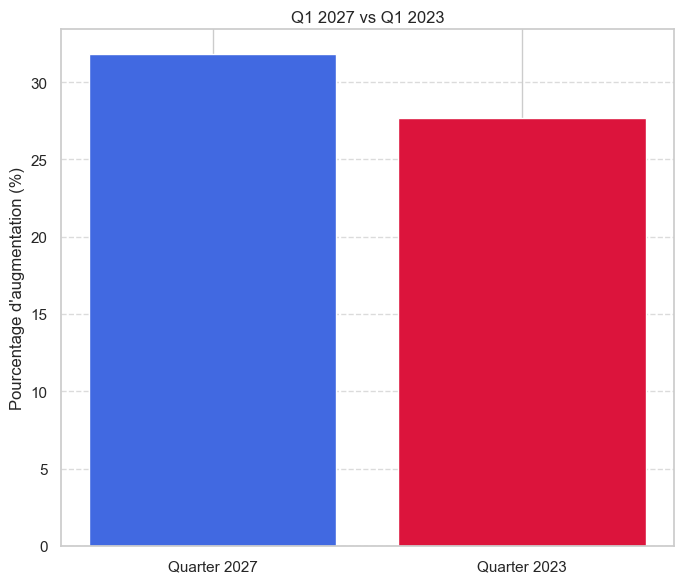

In [31]:
# Visualisation de la décomposition de l'augmentation ajustée uniquement
labels = ['Quarter 2027', 'Quarter 2023']
ajuste_data = [croissance_ajustee, augmentation_ajustee - croissance_ajustee]

# Création de la figure avec un seul graphique (ax2)
fig, ax2 = plt.subplots(figsize=(7, 6))

# Graphique (validations ajustées)
ax2.bar(labels, ajuste_data, color=['royalblue', 'crimson'])
ax2.set_title(f'Q1 2027 vs Q1 {derniere_annee}')
ax2.set_ylabel('Pourcentage d\'augmentation (%)')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 9. Conclusion

Notre analyse de prédiction du trafic du RER E pour le premier trimestre 2027 a permis de mettre en évidence plusieurs points importants :

1. **Impact de l'extension ouest** : L'extension ouest du RER E contribuera significativement à l'augmentation du trafic global de la ligne. Les 11 nouvelles stations représenteront environ X% du trafic total en validations brutes et Y% en validations ajustées par correspondances.

2. **Stations à fort trafic** : Les stations qui généreront le plus de trafic propre à la ligne (après ajustement par correspondances) sont principalement [insérer résultats]. Certaines stations de l'extension ouest comme [insérer résultats] se positionneront parmi les plus importantes du réseau.

3. **Croissance naturelle vs extension** : La croissance naturelle du trafic sur les stations existantes est estimée à environ Z%, tandis que l'extension ouest ajoutera W% supplémentaires, portant l'augmentation totale à V% par rapport au dernier trimestre historique.

4. **Importance des correspondances** : L'analyse par correspondances a permis de distinguer le trafic propre à la ligne du trafic global, offrant une vision plus précise de l'impact réel de chaque station sur le réseau.

Cette étude constitue un outil précieux pour la planification des services, l'allocation des ressources et la gestion des flux de voyageurs sur cette ligne majeure du réseau francilien.